In [1]:
import logging
import tensorflow as tf

from src.common.logs import setup_logging
from src.models_service.models_service import TensorflowModelTuningService as TFMTS
from env import Env


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

config = {
    'AV': {
        'key': '',
        'ticker': 'VGT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.07,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': [20, 40, 120],
        'shuffle_buffer_size' : [1], # In % from dataset len. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'batch_size' : [32, 64, 128],
        'epochs' : [500],
# ----------------------------------
        'optimizer': 'adam',
        'loss': 'huber_loss',
        'metrics': ['mae', 'mse'],
    },
    'plots': {
        'loss_zoom': 0.9,
        'show': False,
    },
}

2023-10-20 23:38:03.363867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 23:38:03.363920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 23:38:03.363943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 23:38:03.370383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Grig Search

2023-10-20 23:38:06.639215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:38:06.643427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:38:06.643475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:38:06.644553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:38:06.644602: I tensorflow/compile

Epoch 1/100


2023-10-20 23:38:21.143845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-20 23:38:22.609401: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa6a4217180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-20 23:38:22.609443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-10-20 23:38:22.614355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-20 23:38:22.697890: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 [==============================] - 9s 15ms/step - loss: 91.5226 - mae: 92.0214 - mse: 18827.4766
Epoch 2/100


2023-10-20 23:38:24.405718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175
2023-10-20 23:38:24.405782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338


72/72 [==============================] - 2s 14ms/step - loss: 68.4536 - mae: 68.9520 - mse: 12784.1445
Epoch 3/100
72/72 [==============================] - 2s 13ms/step - loss: 68.3422 - mae: 68.8401 - mse: 12949.5137
Epoch 4/100
72/72 [==============================] - 2s 13ms/step - loss: 68.3518 - mae: 68.8493 - mse: 13081.8916
Epoch 5/100
72/72 [==============================] - 2s 14ms/step - loss: 68.3709 - mae: 68.8689 - mse: 13005.5264
Epoch 6/100
72/72 [==============================] - 2s 13ms/step - loss: 68.3358 - mae: 68.8342 - mse: 12975.4258
Epoch 7/100
72/72 [==============================] - 2s 13ms/step - loss: 68.3684 - mae: 68.8656 - mse: 12938.8408
Epoch 8/100
72/72 [==============================] - 2s 14ms/step - loss: 68.3637 - mae: 68.8620 - mse: 12896.2910
Epoch 9/100
72/72 [==============================] - 2s 14ms/step - loss: 68.1489 - mae: 68.6465 - mse: 12921.3779
Epoch 10/100
72/72 [==============================] - 2s 13ms/step - loss: 51.8142 - mae: 52

2023-10-20 23:41:06 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W20_SBS1_B64_E100_P42113_2023_10_20__23_38.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W20_SBS1_B64_E100_P42113_2023_10_20__23_38.png"
2023-10-20 23:41:06 - __main__ - INFO - Model saved as VGT_LSTM_W20_SBS1_B64_E100_P42113_2023_10_20__23_38.keras
2023-10-20 23:41:06 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B64_E100_P42113_2023_10_20__23_38_scalers.pkl"
2023-10-20 23:41:06 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:41:06 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:41:06 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:41:06 - src.models_service.

328/328 [==============================] - 3s 6ms/step


2023-10-20 23:41:09.417241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:41:09 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:41:09 - src.models_service.models_service - INFO - (Prediction -2 - [420.94086])
2023-10-20 23:41:09 - src.models_service.models_service - INFO - (Prediction -1 - [416.0804])
2023-10-20 23:41:09 - src.models_service.models_service - INFO - Predicted shape: (328, 1)
2023-10-20 23:41:09 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:41:09 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:41:09 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023-

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:41:10 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:41:10 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:41:10 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:41:11 - __main__ - INFO - Last window elements: [array([0.82071764, 0.50095263]), array([0.77587507, 0.13149915]), array([0.76682928, 0.26996735]), array([0.73132797, 0.33297824]), array([0.74278294, 0.26516452]), array([0.71537284, 0.3578938 ]), array([0.70969081, 0.19078178]), array([0.73871461, 0.0952876 ]), array([0.72921426, 0.32048276]), array([0.75148781, 0.07478125]), array([0.71419098, 0.08804207]), array([0.70880441, 0.09877502]), array([0.71005446, 0.09957798]), array([0.72630506, 0.07976293]), array([0.71114541, 0.09810185]), array([0.72216854, 0.06353187]), array([0.741942  , 0.08685781]), array([0.76980667, 0.18143492]

Epoch 1/100
36/36 [==============================] - 5s 17ms/step - loss: 109.3362 - mae: 109.8362 - mse: 22685.5938
Epoch 2/100


2023-10-20 23:41:21.610308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175
2023-10-20 23:41:21.610365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338


36/36 [==============================] - 1s 14ms/step - loss: 73.9161 - mae: 74.4137 - mse: 14737.7432
Epoch 3/100
36/36 [==============================] - 1s 14ms/step - loss: 68.5721 - mae: 69.0713 - mse: 12527.4375
Epoch 4/100
36/36 [==============================] - 1s 15ms/step - loss: 68.3198 - mae: 68.8167 - mse: 13081.6006
Epoch 5/100
36/36 [==============================] - 1s 15ms/step - loss: 68.3029 - mae: 68.8000 - mse: 13134.0654
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 68.3137 - mae: 68.8119 - mse: 12886.0332
Epoch 7/100
36/36 [==============================] - 1s 14ms/step - loss: 68.3133 - mae: 68.8104 - mse: 13134.1709
Epoch 8/100
36/36 [==============================] - 1s 15ms/step - loss: 68.3454 - mae: 68.8435 - mse: 13036.0576
Epoch 9/100
36/36 [==============================] - 1s 14ms/step - loss: 68.3351 - mae: 68.8327 - mse: 13011.6729
Epoch 10/100
36/36 [==============================] - 1s 15ms/step - loss: 68.3282 - mae: 68

2023-10-20 23:43:18 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W20_SBS1_B128_E100_P42113_2023_10_20__23_41.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W20_SBS1_B128_E100_P42113_2023_10_20__23_41.png"
2023-10-20 23:43:18 - __main__ - INFO - Model saved as VGT_LSTM_W20_SBS1_B128_E100_P42113_2023_10_20__23_41.keras
2023-10-20 23:43:18 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B128_E100_P42113_2023_10_20__23_41_scalers.pkl"
2023-10-20 23:43:18 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:43:18 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:43:18 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:43:18 - src.models_serv

328/328 [==============================] - 2s 6ms/step


2023-10-20 23:43:21.610834: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:43:21 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:43:21 - src.models_service.models_service - INFO - (Prediction -2 - [430.66168])
2023-10-20 23:43:21 - src.models_service.models_service - INFO - (Prediction -1 - [428.3449])
2023-10-20 23:43:21 - src.models_service.models_service - INFO - Predicted shape: (328, 1)
2023-10-20 23:43:21 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:43:21 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:43:21 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023-

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:43:23 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:43:23 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:43:23 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:43:24 - __main__ - INFO - Last window elements: [array([0.88199263, 0.09940676]), array([0.85676443, 0.09127493]), array([0.85960544, 0.05039719]), array([0.8461504 , 0.06768591]), array([0.82474051, 0.07613323]), array([0.82233133, 0.41426833]), array([0.83767281, 0.09017766]), array([0.81553563, 0.05982494]), array([0.81655839, 0.1025339 ]), array([0.83417268, 0.05615533]), array([0.83049073, 0.06169882]), array([0.81339919, 0.07005519]), array([0.78933012, 0.11471801]), array([0.80314881, 0.0981471 ]), array([0.77037487, 0.1082372 ]), array([0.77928429, 0.25991655]), array([0.81314918, 0.08704305]), array([0.77694329, 0.09376729]

Epoch 1/100
72/72 [==============================] - 6s 18ms/step - loss: 92.0403 - mae: 92.5397 - mse: 18739.2031
Epoch 2/100
72/72 [==============================] - 2s 17ms/step - loss: 68.6947 - mae: 69.1934 - mse: 12805.4756
Epoch 3/100
72/72 [==============================] - 2s 16ms/step - loss: 68.5199 - mae: 69.0170 - mse: 13155.4463
Epoch 4/100
72/72 [==============================] - 2s 15ms/step - loss: 68.5434 - mae: 69.0414 - mse: 12975.9541
Epoch 5/100
72/72 [==============================] - 2s 15ms/step - loss: 68.5169 - mae: 69.0149 - mse: 13039.7158
Epoch 6/100
72/72 [==============================] - 2s 17ms/step - loss: 68.5011 - mae: 68.9998 - mse: 13001.7061
Epoch 7/100
72/72 [==============================] - 2s 17ms/step - loss: 68.5090 - mae: 69.0062 - mse: 13091.2051
Epoch 8/100
72/72 [==============================] - 2s 16ms/step - loss: 68.4904 - mae: 68.9886 - mse: 12908.7930
Epoch 9/100
72/72 [==============================] - 2s 15ms/step - loss: 67.672

2023-10-20 23:46:45 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W40_SBS1_B64_E100_P42113_2023_10_20__23_43.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W40_SBS1_B64_E100_P42113_2023_10_20__23_43.png"
2023-10-20 23:46:45 - __main__ - INFO - Model saved as VGT_LSTM_W40_SBS1_B64_E100_P42113_2023_10_20__23_43.keras
2023-10-20 23:46:45 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W40_SBS1_B64_E100_P42113_2023_10_20__23_43_scalers.pkl"
2023-10-20 23:46:45 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:46:45 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:46:45 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:46:45 - src.models_service.

308/308 [==============================] - 4s 8ms/step


2023-10-20 23:46:49.951530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:46:50 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:46:50 - src.models_service.models_service - INFO - (Prediction -2 - [420.50046])
2023-10-20 23:46:50 - src.models_service.models_service - INFO - (Prediction -1 - [415.45493])
2023-10-20 23:46:50 - src.models_service.models_service - INFO - Predicted shape: (308, 1)
2023-10-20 23:46:50 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:46:50 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:46:50 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:46:51 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:46:51 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:46:51 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:46:52 - __main__ - INFO - Last window elements: [array([0.88199263, 0.09940676]), array([0.85676443, 0.09127493]), array([0.85960544, 0.05039719]), array([0.8461504 , 0.06768591]), array([0.82474051, 0.07613323]), array([0.82233133, 0.41426833]), array([0.83767281, 0.09017766]), array([0.81553563, 0.05982494]), array([0.81655839, 0.1025339 ]), array([0.83417268, 0.05615533]), array([0.83049073, 0.06169882]), array([0.81339919, 0.07005519]), array([0.78933012, 0.11471801]), array([0.80314881, 0.0981471 ]), array([0.77037487, 0.1082372 ]), array([0.77928429, 0.25991655]), array([0.81314918, 0.08704305]), array([0.77694329, 0.09376729]

Epoch 1/100
36/36 [==============================] - 5s 22ms/step - loss: 109.8592 - mae: 110.3592 - mse: 22851.8496
Epoch 2/100
36/36 [==============================] - 1s 17ms/step - loss: 74.9376 - mae: 75.4349 - mse: 14972.8125
Epoch 3/100
36/36 [==============================] - 1s 17ms/step - loss: 68.6747 - mae: 69.1738 - mse: 12537.8135
Epoch 4/100
36/36 [==============================] - 1s 19ms/step - loss: 68.4986 - mae: 68.9959 - mse: 13128.2500
Epoch 5/100
36/36 [==============================] - 1s 19ms/step - loss: 68.5043 - mae: 69.0028 - mse: 12997.0547
Epoch 6/100
36/36 [==============================] - 1s 18ms/step - loss: 68.5004 - mae: 68.9976 - mse: 13136.4951
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 68.4924 - mae: 68.9904 - mse: 13126.0596
Epoch 8/100
36/36 [==============================] - 1s 17ms/step - loss: 68.5227 - mae: 69.0204 - mse: 13106.0605
Epoch 9/100
36/36 [==============================] - 1s 16ms/step - loss: 68.5

2023-10-20 23:49:18 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W40_SBS1_B128_E100_P42113_2023_10_20__23_46.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W40_SBS1_B128_E100_P42113_2023_10_20__23_46.png"
2023-10-20 23:49:18 - __main__ - INFO - Model saved as VGT_LSTM_W40_SBS1_B128_E100_P42113_2023_10_20__23_46.keras
2023-10-20 23:49:18 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W40_SBS1_B128_E100_P42113_2023_10_20__23_46_scalers.pkl"
2023-10-20 23:49:18 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:49:18 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:49:18 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:49:18 - src.models_serv

308/308 [==============================] - 3s 7ms/step


2023-10-20 23:49:21.652858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:49:21 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:49:21 - src.models_service.models_service - INFO - (Prediction -2 - [434.17065])
2023-10-20 23:49:21 - src.models_service.models_service - INFO - (Prediction -1 - [431.66125])
2023-10-20 23:49:21 - src.models_service.models_service - INFO - Predicted shape: (308, 1)
2023-10-20 23:49:21 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:49:21 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:49:21 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:49:22 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:49:22 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:49:22 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:49:23 - __main__ - INFO - Last window elements: [array([0.79028869, 0.27262043]), array([0.82643564, 0.10124606]), array([0.81116452, 0.15056365]), array([0.79310239, 0.12130531]), array([0.77469989, 0.16627067]), array([0.80267804, 0.07747957]), array([0.83417331, 0.10157724]), array([0.84386242, 0.06253423]), array([0.86451134, 0.07708761]), array([0.86217415, 0.074357  ]), array([0.87690069, 0.06289785]), array([0.86267336, 0.05918208]), array([0.88669735, 0.05202505]), array([0.88449272, 0.04676612]), array([0.89612952, 0.07841583]), array([0.9172212 , 0.29879733]), array([0.90244793, 0.06293015]), array([0.88894743, 0.08028331]

Epoch 1/100
72/72 [==============================] - 6s 20ms/step - loss: 92.8600 - mae: 93.3589 - mse: 19164.5449
Epoch 2/100


2023-10-20 23:49:35.773626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175
2023-10-20 23:49:35.773683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338


72/72 [==============================] - 2s 21ms/step - loss: 68.7927 - mae: 69.2913 - mse: 12810.2549
Epoch 3/100
72/72 [==============================] - 2s 20ms/step - loss: 68.6878 - mae: 69.1867 - mse: 13097.4766
Epoch 4/100
72/72 [==============================] - 2s 18ms/step - loss: 68.8616 - mae: 69.3599 - mse: 12898.5215
Epoch 5/100
72/72 [==============================] - 2s 19ms/step - loss: 68.6808 - mae: 69.1788 - mse: 13077.6523
Epoch 6/100
72/72 [==============================] - 2s 20ms/step - loss: 68.8433 - mae: 69.3410 - mse: 12990.6406
Epoch 7/100
72/72 [==============================] - 2s 19ms/step - loss: 68.6586 - mae: 69.1563 - mse: 13163.2773
Epoch 8/100
72/72 [==============================] - 2s 18ms/step - loss: 68.6518 - mae: 69.1502 - mse: 12907.7256
Epoch 9/100
72/72 [==============================] - 2s 18ms/step - loss: 59.1443 - mae: 59.6402 - mse: 10709.3291
Epoch 10/100
72/72 [==============================] - 2s 18ms/step - loss: 12.5540 - mae: 13

2023-10-20 23:53:13 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W60_SBS1_B64_E100_P42113_2023_10_20__23_49.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W60_SBS1_B64_E100_P42113_2023_10_20__23_49.png"
2023-10-20 23:53:13 - __main__ - INFO - Model saved as VGT_LSTM_W60_SBS1_B64_E100_P42113_2023_10_20__23_49.keras
2023-10-20 23:53:13 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W60_SBS1_B64_E100_P42113_2023_10_20__23_49_scalers.pkl"
2023-10-20 23:53:13 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:53:13 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:53:13 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:53:13 - src.models_service.

288/288 [==============================] - 3s 8ms/step


2023-10-20 23:53:16.431378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:53:16 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:53:16 - src.models_service.models_service - INFO - (Prediction -2 - [421.33276])
2023-10-20 23:53:16 - src.models_service.models_service - INFO - (Prediction -1 - [415.70325])
2023-10-20 23:53:16 - src.models_service.models_service - INFO - Predicted shape: (288, 1)
2023-10-20 23:53:16 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:53:16 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:53:16 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:53:17 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:53:17 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:53:17 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:53:18 - __main__ - INFO - Last window elements: [array([0.79028869, 0.27262043]), array([0.82643564, 0.10124606]), array([0.81116452, 0.15056365]), array([0.79310239, 0.12130531]), array([0.77469989, 0.16627067]), array([0.80267804, 0.07747957]), array([0.83417331, 0.10157724]), array([0.84386242, 0.06253423]), array([0.86451134, 0.07708761]), array([0.86217415, 0.074357  ]), array([0.87690069, 0.06289785]), array([0.86267336, 0.05918208]), array([0.88669735, 0.05202505]), array([0.88449272, 0.04676612]), array([0.89612952, 0.07841583]), array([0.9172212 , 0.29879733]), array([0.90244793, 0.06293015]), array([0.88894743, 0.08028331]

Epoch 1/100
36/36 [==============================] - 5s 25ms/step - loss: 110.1880 - mae: 110.6880 - mse: 22958.5840
Epoch 2/100


2023-10-20 23:53:30.447291: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175
2023-10-20 23:53:30.447388: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338


36/36 [==============================] - 1s 20ms/step - loss: 74.6616 - mae: 75.1595 - mse: 14851.2734
Epoch 3/100
36/36 [==============================] - 1s 20ms/step - loss: 68.9268 - mae: 69.4255 - mse: 12477.4277
Epoch 4/100
36/36 [==============================] - 1s 21ms/step - loss: 68.6709 - mae: 69.1693 - mse: 13141.4180
Epoch 5/100
36/36 [==============================] - 2s 21ms/step - loss: 68.6716 - mae: 69.1692 - mse: 13145.4834
Epoch 6/100
36/36 [==============================] - 2s 20ms/step - loss: 68.6863 - mae: 69.1845 - mse: 13089.5693
Epoch 7/100
36/36 [==============================] - 2s 20ms/step - loss: 68.6798 - mae: 69.1784 - mse: 12890.1797
Epoch 8/100
36/36 [==============================] - 1s 20ms/step - loss: 68.6691 - mae: 69.1656 - mse: 13241.5371
Epoch 9/100
36/36 [==============================] - 1s 19ms/step - loss: 68.6972 - mae: 69.1958 - mse: 12920.5488
Epoch 10/100
36/36 [==============================] - 1s 19ms/step - loss: 68.6682 - mae: 69

2023-10-20 23:56:04 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W60_SBS1_B128_E100_P42113_2023_10_20__23_53.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W60_SBS1_B128_E100_P42113_2023_10_20__23_53.png"
2023-10-20 23:56:04 - __main__ - INFO - Model saved as VGT_LSTM_W60_SBS1_B128_E100_P42113_2023_10_20__23_53.keras
2023-10-20 23:56:04 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W60_SBS1_B128_E100_P42113_2023_10_20__23_53_scalers.pkl"
2023-10-20 23:56:04 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-20 23:56:04 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-20 23:56:04 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-20 23:56:04 - src.models_serv

288/288 [==============================] - 3s 9ms/step


2023-10-20 23:56:07.911498: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:56:08 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-20 23:56:08 - src.models_service.models_service - INFO - (Prediction -2 - [429.30573])
2023-10-20 23:56:08 - src.models_service.models_service - INFO - (Prediction -1 - [428.18796])
2023-10-20 23:56:08 - src.models_service.models_service - INFO - Predicted shape: (288, 1)
2023-10-20 23:56:08 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:56:08 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-20 23:56:08 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023

/workspaces/P7-Trading-Bot/models_trained


2023-10-20 23:56:09 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-20 23:56:09 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-20 23:56:09 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-20 23:56:10 - __main__ - INFO - Last window elements: [array([0.9676958 , 0.05018804]), array([0.9843203 , 0.06155593]), array([0.9690321 , 0.06838711]), array([0.9522264 , 0.09043998]), array([0.97895244, 0.07552267]), array([0.94894499, 0.09550011]), array([0.94545055, 0.06264056]), array([0.93367386, 0.08678926]), array([0.960404  , 0.07478506]), array([0.97256644, 0.05467706]), array([0.97819384, 0.04590375]), array([1.       , 0.0780519]), array([0.9926027 , 0.07898785]), array([0.99269346, 0.05586528]), array([0.98720221, 0.05096678]), array([0.98200594, 0.06082182]), array([0.99069664, 0.08479077]), array([0.97744503, 0.12515803]),

Epoch 1/100
71/71 [==============================] - 7s 31ms/step - loss: 93.9075 - mae: 94.4066 - mse: 19216.0742
Epoch 2/100


2023-10-20 23:56:23.808655: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10695409952548252512
2023-10-20 23:56:23.808724: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-20 23:56:23.808762: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16633603485086177327
2023-10-20 23:56:23.808783: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175


71/71 [==============================] - 3s 28ms/step - loss: 69.3238 - mae: 69.8228 - mse: 12692.9795
Epoch 3/100
71/71 [==============================] - 3s 29ms/step - loss: 69.2066 - mae: 69.7052 - mse: 13177.2207
Epoch 4/100
71/71 [==============================] - 3s 25ms/step - loss: 69.2175 - mae: 69.7164 - mse: 13120.2363
Epoch 5/100
71/71 [==============================] - 3s 26ms/step - loss: 69.2603 - mae: 69.7589 - mse: 13103.3340
Epoch 6/100
71/71 [==============================] - 3s 28ms/step - loss: 69.2269 - mae: 69.7257 - mse: 12940.5420
Epoch 7/100
71/71 [==============================] - 3s 26ms/step - loss: 69.1964 - mae: 69.6945 - mse: 13082.4121
Epoch 8/100
71/71 [==============================] - 3s 28ms/step - loss: 69.1090 - mae: 69.6071 - mse: 13157.1572
Epoch 9/100
71/71 [==============================] - 3s 27ms/step - loss: 65.1532 - mae: 65.6496 - mse: 12189.1133
Epoch 10/100
71/71 [==============================] - 3s 27ms/step - loss: 33.3519 - mae: 33

2023-10-21 00:01:16 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W120_SBS1_B64_E100_P42113_2023_10_20__23_56.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W120_SBS1_B64_E100_P42113_2023_10_20__23_56.png"
2023-10-21 00:01:16 - __main__ - INFO - Model saved as VGT_LSTM_W120_SBS1_B64_E100_P42113_2023_10_20__23_56.keras
2023-10-21 00:01:16 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W120_SBS1_B64_E100_P42113_2023_10_20__23_56_scalers.pkl"
2023-10-21 00:01:16 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-21 00:01:16 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-21 00:01:16 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-21 00:01:16 - src.models_serv

228/228 [==============================] - 4s 14ms/step


2023-10-21 00:01:21.071719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-21 00:01:21 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-21 00:01:21 - src.models_service.models_service - INFO - (Prediction -2 - [423.9292])
2023-10-21 00:01:21 - src.models_service.models_service - INFO - (Prediction -1 - [418.41327])
2023-10-21 00:01:21 - src.models_service.models_service - INFO - Predicted shape: (228, 1)
2023-10-21 00:01:21 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-21 00:01:21 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-21 00:01:21 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023-

/workspaces/P7-Trading-Bot/models_trained


2023-10-21 00:01:22 - __main__ - INFO - Last element in dataset: [0.75991994 0.16624858]
2023-10-21 00:01:22 - __main__ - INFO - ----------------------------------------------------------------------------------------------------
2023-10-21 00:01:22 - __main__ - INFO - -------------------windowed_dataset_X() - window()-------------------------
2023-10-21 00:01:23 - __main__ - INFO - Last window elements: [array([0.9676958 , 0.05018804]), array([0.9843203 , 0.06155593]), array([0.9690321 , 0.06838711]), array([0.9522264 , 0.09043998]), array([0.97895244, 0.07552267]), array([0.94894499, 0.09550011]), array([0.94545055, 0.06264056]), array([0.93367386, 0.08678926]), array([0.960404  , 0.07478506]), array([0.97256644, 0.05467706]), array([0.97819384, 0.04590375]), array([1.       , 0.0780519]), array([0.9926027 , 0.07898785]), array([0.99269346, 0.05586528]), array([0.98720221, 0.05096678]), array([0.98200594, 0.06082182]), array([0.99069664, 0.08479077]), array([0.97744503, 0.12515803]),

Epoch 1/100
36/36 [==============================] - 6s 33ms/step - loss: 111.4340 - mae: 111.9340 - mse: 23297.2598
Epoch 2/100


2023-10-21 00:01:36.460078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-21 00:01:36.460163: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10868060807507803175


36/36 [==============================] - 2s 31ms/step - loss: 75.4494 - mae: 75.9480 - mse: 15052.3701
Epoch 3/100
36/36 [==============================] - 2s 29ms/step - loss: 69.4041 - mae: 69.9033 - mse: 12535.8887
Epoch 4/100
36/36 [==============================] - 2s 30ms/step - loss: 69.1836 - mae: 69.6823 - mse: 13067.3105
Epoch 5/100
36/36 [==============================] - 2s 30ms/step - loss: 69.2032 - mae: 69.7019 - mse: 13167.9551
Epoch 6/100
36/36 [==============================] - 2s 32ms/step - loss: 69.1858 - mae: 69.6847 - mse: 13143.5879
Epoch 7/100
36/36 [==============================] - 2s 32ms/step - loss: 69.1926 - mae: 69.6910 - mse: 13248.5156
Epoch 8/100
36/36 [==============================] - 2s 27ms/step - loss: 69.2215 - mae: 69.7205 - mse: 12997.0371
Epoch 9/100
36/36 [==============================] - 2s 30ms/step - loss: 69.1843 - mae: 69.6831 - mse: 13021.4902
Epoch 10/100
36/36 [==============================] - 2s 28ms/step - loss: 69.1825 - mae: 69

2023-10-21 00:05:03 - src.common.plots - INFO - Plot "Loss-VGT_LSTM_W120_SBS1_B128_E100_P42113_2023_10_21__00_01.png" saved to "/workspaces/P7-Trading-Bot/figures/Loss-VGT_LSTM_W120_SBS1_B128_E100_P42113_2023_10_21__00_01.png"
2023-10-21 00:05:03 - __main__ - INFO - Model saved as VGT_LSTM_W120_SBS1_B128_E100_P42113_2023_10_21__00_01.keras
2023-10-21 00:05:03 - __main__ - INFO - Scalers saved: "/workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W120_SBS1_B128_E100_P42113_2023_10_21__00_01_scalers.pkl"
2023-10-21 00:05:03 - src.models_service.models_service - INFO - ---------------------------------model_forecast() - X_df shape-------------------------------------
2023-10-21 00:05:03 - src.models_service.models_service - INFO - X_df.shape: (347, 2)
2023-10-21 00:05:03 - src.models_service.models_service - INFO - Last 2 records:
            Adj Close    Volume
Date                           
2023-10-18     426.07  397930.0
2023-10-19     420.23  318303.0
2023-10-21 00:05:03 - src.models_

228/228 [==============================] - 4s 13ms/step


2023-10-21 00:05:07.885249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4607182358992434338
2023-10-21 00:05:08 - src.models_service.models_service - INFO - ------------------------model_forecast() - forecast for 2 last ---------------------------
2023-10-21 00:05:08 - src.models_service.models_service - INFO - (Prediction -2 - [426.14743])
2023-10-21 00:05:08 - src.models_service.models_service - INFO - (Prediction -1 - [422.20023])
2023-10-21 00:05:08 - src.models_service.models_service - INFO - Predicted shape: (228, 1)
2023-10-21 00:05:08 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-10-21 00:05:08 - src.models_service.models_service - INFO - df_test_y.shape after adding next day (tomorrow) to existing data: (348,)
2023-10-21 00:05:08 - src.models_service.models_service - INFO - df_test_y.tail(3):
2023-10-18    420.23
2023

/workspaces/P7-Trading-Bot/models_trained


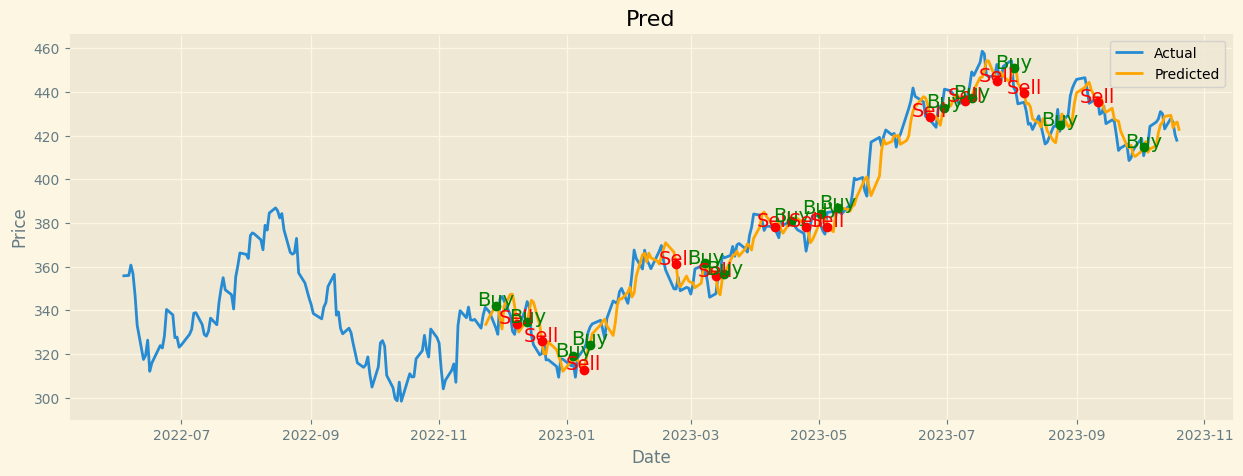

In [2]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 2)), # where 2 is the number of features
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        ]
    )

# model.save_weights(f'{Env.PROJECT_ROOT}/models_trained/keep/my_model_weights.h5')
grid_search_service = TFMTS(model, config)
grid_search_service.grid_search(logger, verbose=True)